In [1]:
import os
import json
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pytorch_lightning as pl


random_seed = 1337
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
train_ratio = 0.8  # 80% for training, 20% for validation

BATCH_SIZE=64
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count() / 2) 

print(NUM_WORKERS)
print(AVAIL_GPUS)

8
1


In [ ]:
json_dir = '../learning-data/'

all_segments = []
all_grass_positions = []
all_starting_points = []

# Helper function to compute length and angle
def compute_length_and_angle(x1, y1, x2, y2):
    length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    angle = np.arctan2(y2 - y1, x2 - x1)
    return length, angle

failed_file = None
# Iterate through JSON files
for filename in os.listdir(json_dir):
    if filename.endswith('.json'):
        # delete failed file if it exists
        if failed_file is not None:
            os.remove(failed_file)
            failed_file = None
        with open(os.path.join(json_dir, filename), 'r') as f:
            try:
                ground_data = json.load(f)
                segments = ground_data['segments']
                grass_positions = ground_data['grassPositions']
                # check if ground data contains starting point
                if 'startingPoint' in ground_data:
                    starting_point = ground_data['startingPoint']
                else:
                    starting_point = all_starting_points[-1]

                # Append data to lists
                all_segments.append(segments)
                all_grass_positions.append(grass_positions)
                all_starting_points.append(starting_point)
            except:
                print(f'Error reading {filename}')
                # delete the file
                failed_file = os.path.join(json_dir, filename)
                continue


In [ ]:
# Serialize the data and save it to a file for later use
with open('../learning-data/ground_data.pkl', 'wb') as f:
    pickle.dump((all_segments, all_grass_positions, all_starting_points), f)
    


In [ ]:
# Load the serialized data
with open('../learning-data/ground_data.pkl', 'rb') as f:
    all_segments, all_grass_positions, all_starting_points = pickle.load(f)

In [ ]:
segments_list = []
for segment in all_segments:
    #segment_tensor = torch.tensor([[point['x'], point['y'], point['length'], point['angleToNextVector']] for point in segment], dtype=torch.float32)
    #segment_tensor = torch.tensor([[point['x'], point['y']] for point in segment], dtype=torch.float32)
    segment_tensor = torch.tensor([[point['length'], point['angleToNextVector']] for point in segment], dtype=torch.float32)
    segments_list.append(segment_tensor)
segments_tensor = torch.stack(segments_list)

# Convert grass positions to tensor
grass_positions_tensor = torch.tensor(all_grass_positions, dtype=torch.int64)  # Assuming grass positions are integers

# Convert starting points to tensor
starting_points_tensor = torch.tensor(all_starting_points, dtype=torch.float32)

# Serialize the tensors
with open('../learning-data/ground_tensors.pkl', 'wb') as f:
    pickle.dump((segments_tensor, grass_positions_tensor, starting_points_tensor), f)


In [2]:
# Load the serialized tensors
with open('../learning-data/ground_tensors.pkl', 'rb') as f:
    segments_tensor, grass_positions_tensor, starting_points_tensor = pickle.load(f)
    
# keep only the first 5000 samples
print(segments_tensor.shape)


torch.Size([102316, 855, 2])


In [3]:
train_size = int((len(segments_tensor) * train_ratio) )# % for training
val_size = int(len(segments_tensor) - train_size)  # Remaining % for validation

# Split the data into training and validation sets
train_dataset, val_dataset = random_split(segments_tensor, [train_size, val_size])

# Create DataLoader instances for training and validation sets
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# Optionally, you can print the sizes of the datasets
print("Training dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))

Training dataset size: 81852
Validation dataset size: 20464


In [4]:
# Define the discriminator model with dropout
class FNNDiscriminator(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, output_size, dropout_prob=0.45):
        super(FNNDiscriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc3(x)))
        x = self.dropout(self.relu(self.fc4(x)))
        x = self.sigmoid(self.fc5(x))
        return x

# Assuming input_size_discriminator = 1710


# Define the generator model with dropout
# class LSTMGenerator(nn.Module):
#     def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, output_size, dropout_prob=0.75):
#         super(LSTMGenerator, self).__init__()
#         self.hidden_size1 = hidden_size1
#         self.lstm = nn.LSTM(input_size, hidden_size1, batch_first=True)
#         self.fc1 = nn.Linear(hidden_size1, hidden_size2)
#         self.fc2 = nn.Linear(hidden_size2, hidden_size3)
#         self.fc3 = nn.Linear(hidden_size3, hidden_size4)
#         self.fc4 = nn.Linear(hidden_size4, output_size)
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(dropout_prob)

#     def forward(self, x):
#         h0 = torch.zeros(1, x.size(0), self.hidden_size1).to(x.device)
#         c0 = torch.zeros(1, x.size(0), self.hidden_size1).to(x.device)
#         out, _ = self.lstm(x, (h0, c0))
        
#         out = out[:, -1, :]  # Take the output from the last time step
        
#         out = self.dropout(self.relu(self.fc1(out)))
#         out = self.dropout(self.relu(self.fc2(out)))
#         out = self.dropout(self.relu(self.fc3(out)))
#         out = self.fc4(out)
#         return out
    
class FNNGenerator(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, hidden_size5, output_size, dropout_prob=0.95):
        super(FNNGenerator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, hidden_size5)
        self.fc6 = nn.Linear(hidden_size5, output_size)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc3(x)))
        x = self.dropout(self.relu(self.fc4(x)))
        x = self.dropout(self.relu(self.fc5(x)))
        x = self.tanh(self.fc6(x))
        return x

In [32]:
# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define hyperparameters
input_size_discriminator = 1710  # Input size should match the length of each segment for length and angle only
hidden_size_discriminator1 = 128
hidden_size_discriminator2 = 128
hidden_size_discriminator3 = 32
hidden_size_discriminator4 = 16
output_size_discriminator = 1

input_size_generator = 64
hidden_size_generator1 = 128
hidden_size_generator2 = 256
hidden_size_generator3 = 512
hidden_size_generator4 = 1024
hidden_size_generator5 = 2048
output_size_generator = 1710  # Output size should match the size of each segment for length and angle only

    
discriminator = FNNDiscriminator(input_size_discriminator, hidden_size_discriminator1,
                                  hidden_size_discriminator2, hidden_size_discriminator3,
                                  hidden_size_discriminator4,
                                  output_size_discriminator).to(device)
generator = FNNGenerator(input_size_generator, hidden_size_generator1, hidden_size_generator2, hidden_size_generator3, hidden_size_generator4, hidden_size_generator5, output_size_generator).to(device)

criterion = nn.BCELoss().to(device)  # Binary Cross-Entropy Loss
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.00001, betas=(0.85, 0.999))
#g_optimizer = optim.Adam(generator.parameters(), lr=0.00001, betas=(0.65, 0.999))
#d_optimizer = optim.Adam(discriminator.parameters(), lr=0.00001)
g_optimizer = optim.Adagrad(generator.parameters(), lr=0.00001)


def gradient_penalty(discriminator, real_data, fake_data):
    batch_size = real_data.size(0)
    epsilon = torch.rand(batch_size, 1, 1).to(real_data.device)
    epsilon = epsilon.expand_as(real_data)

    interpolated = epsilon * real_data + (1 - epsilon) * fake_data
    interpolated = torch.autograd.Variable(interpolated, requires_grad=True)

    interpolated_prob = discriminator(interpolated)

    gradients = torch.autograd.grad(
        outputs=interpolated_prob,
        inputs=interpolated,
        grad_outputs=torch.ones(interpolated_prob.size()).to(real_data.device),
        create_graph=True,
        retain_graph=True
    )[0]

    gradients = gradients.view(batch_size, -1)
    gradient_norm = gradients.norm(2, dim=1)
    return ((gradient_norm - 1) ** 2).mean()

def wasserstein_loss(D_real, D_fake):
    return D_fake.mean() - D_real.mean()

def length_penalty_loss(flat_fake_data, batch_size):
    lengths = flat_fake_data.view(batch_size, -1, 2)[:, :, 0]  # Extract length values
    # Calculate absolute difference for each length from 0.5 and apply ReLU
    penalty = torch.relu(torch.abs(lengths - 0.5))
    # Sum the penalties
    penalty = torch.sum(penalty)
    return penalty

def normalize_angles(angles, min_angle=-60, max_angle=80):
    # Normalize angles to the range [-1, 1]
    return 2 * ((angles - min_angle) / (max_angle - min_angle)) - 1

def denormalize_angles(normalized_angles, min_angle=-60, max_angle=80):
    # Denormalize angles to the range [min_angle, max_angle]
    return ((normalized_angles + 1) / 2) * (max_angle - min_angle) + min_angle


def sequential_penalty_loss(flat_fake_data, batch_size, min_allowed_diff=10):
    angles = flat_fake_data.view(batch_size, -1, 2)[:, :, 1]
    denormalized_angles = denormalize_angles(angles)
    angle_diffs = denormalized_angles[:, 1:] - denormalized_angles[:, :-1]
    penalty = torch.relu(min_allowed_diff - torch.abs(angle_diffs))
    return torch.sum(penalty)

def angle_loss(normalized_angles, min_allowed_diff_normalized=0.001, sequence_length=4):
    """
    Compute the angle loss to penalize long sequences of small differences in normalized angles.
    
    Parameters:
    normalized_angles (torch.Tensor): The tensor of normalized angles.
    min_allowed_diff_normalized (float): The minimum allowed difference in normalized values.
    sequence_length (int): The length of sequences to penalize if differences are below the min allowed difference.
    
    Returns:
    torch.Tensor: The computed angle loss.
    """
    # Compute the absolute differences between consecutive normalized angles
    angle_diffs = torch.abs(normalized_angles[:, 1:] - normalized_angles[:, :-1])
    
    # Create mask for where the angle differences are below the minimum allowed deviation
    small_diff_mask = angle_diffs < min_allowed_diff_normalized
    
    # Create a penalty mask for sequences of small differences
    seq_mask = torch.nn.functional.conv1d(small_diff_mask.float().unsqueeze(1), 
                                          torch.ones((1, 1, sequence_length)).to(normalized_angles.device), 
                                          padding=sequence_length-1)
    penalty_mask = (seq_mask >= sequence_length).float()
    
    # Sum up the penalties for all differences
    total_penalty = torch.sum(penalty_mask)
    
    return total_penalty

def balance_penalty_loss(normalized_angles):
    # Count the number of positive and negative angles
    positive_count = torch.sum(normalized_angles > 0, dim=1)
    negative_count = torch.sum(normalized_angles < 0, dim=1)
    
    # Penalize the difference between positive and negative counts
    imbalance_penalty = torch.abs(positive_count - negative_count)
    
    return torch.sum(imbalance_penalty)

def angle_range_penalty_loss(normalized_fake_data):
    angles = normalized_fake_data[:, 1::2]  # Extract normalized angles

    # Penalize angles outside the range [0, 1]
    penalty_outside_range = torch.relu(-angles) + torch.relu(angles - 1)
    
    # Sum the penalties
    total_penalty = torch.sum(penalty_outside_range)

    return total_penalty


def length_difference_loss(real_lengths, fake_lengths):
    real_avg_length = torch.mean(real_lengths)
    fake_avg_length = torch.mean(fake_lengths)
    return torch.abs(real_avg_length - fake_avg_length)

def sequential_extreme_change_loss(flat_fake_data, batch_size):
    angles = flat_fake_data.view(batch_size, -1, 2)[:, :, 1]
    # The closer the angle is to -1 or 1, the higher the reward
    penalty = torch.relu(-1 - angles) + torch.relu(angles - 1)
    return torch.sum(penalty)
    

# Training loop
num_epochs = 48
lambda_penalty = 3.0  # Weight for the length penalty loss
lambda_difference = 10.0  # Weight for the length difference loss
lambda_angle = 6.0  # Weight for the angle penalty loss
lambda_angle_range = 15.0  # Weight for the angle range penalty loss

for epoch in range(num_epochs):
    # Set the models to training mode
    for real_data in train_dataloader:
        real_data = real_data.float().to(device).view(real_data.size(0), -1)  # Flatten and move to GPU

        real_labels = torch.ones(len(real_data), 1).to(device)
        fake_labels = torch.zeros(len(real_data), 1).to(device)

        # Normalize angles in real data
        normalized_real_data = real_data.clone()
        normalized_real_data[:, 1::2] = normalize_angles(real_data[:, 1::2])

        # Train discriminator
        real_output = discriminator(normalized_real_data)
        d_loss_real = criterion(real_output, real_labels)
        real_score = real_output

        # z = torch.randn(len(real_data), input_size_generator).unsqueeze(1).repeat(1, 855, 1).to(device)
        z = torch.randn(len(real_data), input_size_generator).to(device) # Generate random noise
        fake_data = generator(z)
        #print(fake_data.shape)
        #print(normalized_real_data.shape)
        fake_data = fake_data.view(fake_data.size(0), -1)  # Flatten the fake data
        assert real_data.shape == fake_data.shape, "Shapes of real and fake data must match."
        #print(fake_data.shape)
        fake_output = discriminator(fake_data)
        d_loss_fake = criterion(fake_output, fake_labels)
        fake_score = fake_output

        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Train generator
        # z = torch.randn(len(real_data), input_size_generator).unsqueeze(1).repeat(1, 855, 1).to(device)  # Generate random noise
        z = torch.randn(len(real_data), input_size_generator).to(device) 
        fake_data = generator(z)
        fake_data = fake_data.view(fake_data.size(0), -1)  # Flatten the fake data

        output = discriminator(fake_data)

        g_loss = criterion(output, real_labels)

        # Add the length penalty loss
        length_penalty = length_penalty_loss(fake_data, len(real_data))
        
        # Add the sequential penalty loss
        sequential_penalty = sequential_penalty_loss(fake_data, len(real_data))

        # Add the length difference loss
        real_lengths = torch.norm(real_data.view(len(real_data), -1, 2), dim=2)  # Calculate lengths for real data
        fake_lengths = torch.norm(fake_data.view(len(real_data), -1, 2), dim=2)  # Calculate lengths for fake data
        difference_loss = length_difference_loss(real_lengths, fake_lengths)

        # Add the angle penalty loss
        fake_angles = fake_data[:, 1::2]  # Assuming angles are the second component
        angle_penalty = angle_loss(fake_angles)

        # Add the angle range penalty loss
        angle_range_penalty = angle_range_penalty_loss(fake_data)
        
        # Add the balance penalty loss
        balance_penalty = balance_penalty_loss(fake_angles)
        
        # Add the sequential extreme change loss
        # sequential_penalty_extremes = sequential_extreme_change_loss(fake_data, len(real_data))

        # Calculate the total generator loss
        #total_g_loss = g_loss + lambda_angle_range * angle_range_penalty + lambda_penalty * sequential_penalty + length_penalty * lambda_penalty + balance_penalty * 2
        total_g_loss = g_loss + length_penalty * 4.5 + balance_penalty * 7
        total_g_loss.backward()
        g_optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {total_g_loss.item():.4f}, length_penalty: {length_penalty.item():.4f}, difference_loss: {difference_loss.item():.4f}, angle_penalty: {angle_penalty.item():.4f}, angle_range_penalty: {angle_range_penalty.item():.4f}, balance_penalty: {balance_penalty.item():.4f}, sequential_penalty: {sequential_penalty.item():.4f}')

# Generate new data after training
# z = torch.randn(1, input_size_generator).unsqueeze(1).repeat(1, 855, 1).to(device)  # Generate random noise
# z = torch.randn(len(real_data), input_size_generator).to(device) 
# fake_data = generator(z)
# fake_data = fake_data.view(fake_data.size(0), 855, 2)

# generated_data = []

# for sample in fake_data:
#     segment_data = []
#     for vector in sample:
#         segment_data.append({
#             "length": vector[0].item(),
#             "angleToNextVector": vector[1].item()
#         })
#     generated_data.append({"segments": segment_data})

# print(generated_data)

Epoch [1/50], d_loss: 0.6823, g_loss: 175326.7812, length_penalty: 36643.5391, difference_loss: 20.9044, angle_penalty: 402.0000, angle_range_penalty: 22300.6309, balance_penalty: 1490.0000, sequential_penalty: 150539.3750
Epoch [2/50], d_loss: 0.1336, g_loss: 162021.6406, length_penalty: 33446.5391, difference_loss: 21.0357, angle_penalty: 393.0000, angle_range_penalty: 22710.4492, balance_penalty: 1644.0000, sequential_penalty: 151795.9688
Epoch [3/50], d_loss: 0.1680, g_loss: 149926.2969, length_penalty: 30853.6641, difference_loss: 21.1382, angle_penalty: 325.0000, angle_range_penalty: 22527.9570, balance_penalty: 1582.0000, sequential_penalty: 148811.7812
Epoch [4/50], d_loss: 0.0175, g_loss: 138197.8438, length_penalty: 29129.9883, difference_loss: 20.9062, angle_penalty: 357.0000, angle_range_penalty: 22209.2891, balance_penalty: 1014.0000, sequential_penalty: 145505.5625
Epoch [5/50], d_loss: 0.0111, g_loss: 136255.0781, length_penalty: 27891.1445, difference_loss: 20.8830, ang

[{'segments': [{'length': 0.9947001934051514, 'angleToNextVector': 79.99978637695312}, {'length': 0.9999980926513672, 'angleToNextVector': -58.992408752441406}, {'length': 1.0, 'angleToNextVector': 79.99989318847656}, {'length': 0.9999998211860657, 'angleToNextVector': 79.9996337890625}, {'length': 0.9999982714653015, 'angleToNextVector': -44.40706253051758}, {'length': 1.0, 'angleToNextVector': -30.78527069091797}, {'length': 0.9999932646751404, 'angleToNextVector': -59.99999237060547}, {'length': 1.0, 'angleToNextVector': 79.99343872070312}, {'length': 0.9998183250427246, 'angleToNextVector': 67.77374267578125}, {'length': 0.9999989867210388, 'angleToNextVector': -55.56147003173828}, {'length': 0.9999974966049194, 'angleToNextVector': 79.99998474121094}, {'length': 0.9999995827674866, 'angleToNextVector': -59.97591018676758}, {'length': 1.0, 'angleToNextVector': 79.999267578125}, {'length': 1.0, 'angleToNextVector': -59.989967346191406}, {'length': 1.0, 'angleToNextVector': 78.340530

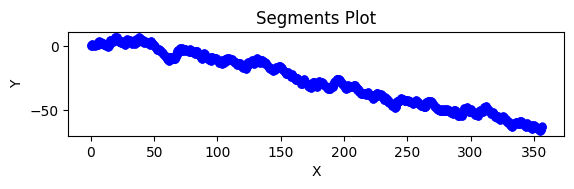

In [49]:
# After training, generate new fake data
# z = torch.randn(1, input_size_generator).unsqueeze(1).repeat(1, 855, 1).to(device)  # Generate random noise


# Evaulate the model after training and plot the generated data

# Set the models to evaluation mode

# Generate new data after training
# Set the models to evaluation mode

generator.train()
discriminator.train()

z = torch.randn(1, input_size_generator).to(device)  # Generate random noise
fake_data = generator(z)
fake_data = fake_data.view(fake_data.size(0), 855, 2)

fake_data[:, :, 1] = denormalize_angles(fake_data[:, :, 1])

generated_data = []

for sample in fake_data:
    segment_data = []
    for vector in sample:
        segment_data.append({
            "length": vector[0].item(),
            "angleToNextVector": vector[1].item()
        })
    generated_data.append({"segments": segment_data})

print(generated_data)

def plot_segments_from_json(data):
    fig, ax = plt.subplots()
    
    for sample in data:
        print("sample", sample)
        segments = sample["segments"]
        x, y = 0, 0  # Starting point
        
        for segment in segments:
            length = segment["length"]
            tmpangle = segment["angleToNextVector"]
            #while tmpangle < 0:
            #    tmpangle = tmpangle + 360
            angle = np.radians(segment["angleToNextVector"])  # Convert angle to radians

            new_x = x + length * np.cos(angle)
            new_y = y + length * np.sin(angle) 
            segment["x"] = new_x
            segment["y"] = new_y
            
            # Plot a line segment from (x, y) to (new_x, new_y)
            ax.plot([x, new_x], [y, new_y], 'bo-', markersize=5)  # 'bo-' for blue line with circle markers

            # Update the current point
            x, y = new_x, new_y

    ax.set_aspect('equal', 'box')
    ax.autoscale()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Segments Plot')
    plt.show()

# Example usage:
plot_segments_from_json(generated_data)

# Save the models




#read ground-1.json and plot the segment

# with open('../learning-data/ground-2.json', 'r') as f:
#     temp_ground_data = json.load(f)
#     temp_segments = temp_ground_data['segments']
#     plot_segments_from_json([{"segments": temp_segments}])



In [97]:
# Save trained discriminator and generator models
torch.save(discriminator.state_dict(), 'discriminator.pth')
torch.save(generator.state_dict(), 'generator.pth')

[{'segments': [{'length': 0.9999995827674866, 'angleToNextVector': -59.99995422363281}, {'length': 0.9999999403953552, 'angleToNextVector': -59.999900817871094}, {'length': 1.0, 'angleToNextVector': 79.99989318847656}, {'length': 0.9999999403953552, 'angleToNextVector': 79.99995422363281}, {'length': 0.9999949336051941, 'angleToNextVector': -47.9551887512207}, {'length': 0.9998552799224854, 'angleToNextVector': -59.9999885559082}, {'length': 0.9999797940254211, 'angleToNextVector': 79.99998474121094}, {'length': 0.9999986290931702, 'angleToNextVector': -60.0}, {'length': 0.9999934434890747, 'angleToNextVector': 79.97755432128906}, {'length': 1.0, 'angleToNextVector': -59.999961853027344}, {'length': 0.9999996423721313, 'angleToNextVector': -59.88458251953125}, {'length': 0.987339973449707, 'angleToNextVector': -30.73885726928711}, {'length': 1.0, 'angleToNextVector': 79.79335021972656}, {'length': 0.9999995827674866, 'angleToNextVector': 26.11835479736328}, {'length': 0.999999940395355

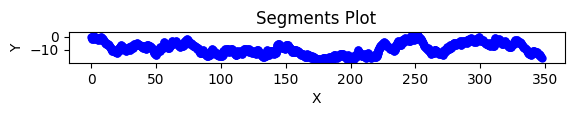

In [72]:
# load the generator and discriminator models from .pth files

new_discriminator = FNNDiscriminator(input_size_discriminator, hidden_size_discriminator1, hidden_size_discriminator2, hidden_size_discriminator3, hidden_size_discriminator4, output_size_discriminator).to(device)
new_generator = FNNGenerator(input_size_generator, hidden_size_generator1, hidden_size_generator2, hidden_size_generator3, hidden_size_generator4, hidden_size_generator5, output_size_generator).to(device)

new_discriminator.load_state_dict(torch.load('discriminator.pth'))
new_generator.load_state_dict(torch.load('generator.pth'))

# Generate new data after training
# z = torch.randn(1, input_size_generator).unsqueeze(1).repeat(1, 855, 1).to(device)  # Generate random noise
z = torch.randn(1, input_size_generator).to(device)

fake_data = new_generator(z)
fake_data = fake_data.view(fake_data.size(0), 855, 2)

fake_data[:, :, 1] = denormalize_angles(fake_data[:, :, 1])

generated_data = []

for sample in fake_data:
    segment_data = []
    for vector in sample:
        segment_data.append({
            "length": vector[0].item(),
            "angleToNextVector": vector[1].item()
        })
    generated_data.append({"segments": segment_data})
    
print(generated_data)

# Example usage:
plot_segments_from_json(generated_data)

    
    